# De  forma general reviso:
1. SP500
  - EDA
  - Comportamiento

2. Comportamiento del sp500 en los diferentes subsectores
  - EDA
  - Comportamiento 

#Instalando librerias para la descarga de datos

In [ ]:
!pip install yfinance
!pip install mplfinance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Imporando las librerias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objs as go
import numpy as np
import seaborn as sns

#Obtención de datos
A partir de la libreria de yahoo finance se obtienen los datos tanto del sp500 como indice (sp500_index) y de todas las empresas que componen el sp500 con los subsectores (sp500_data)

In [ ]:
#@title
# Obtener todos los símbolos de acciones del S&P 500 junto con su sector y subsector
urlEmpresa = 'https://es.wikipedia.org/wiki/Anexo:Compa%C3%B1%C3%ADas_del_S%26P_500'
sp500_empresas = pd.read_html(urlEmpresa, encoding='utf8')[2][['Símbolo', 'Sector GICS', 'Sub-industria GICS']]
sp500_empresas.rename(columns={'Símbolo': 'Symbol', 'Sector GICS': 'Sector', 'Sub-industria GICS': 'Subsector'}, inplace=True)
sp500_empresas['Symbol'] = sp500_empresas['Symbol'].str.strip().replace({'BF.B': 'BF-B', 'BRK.B': 'BRK-B'})

# Definir el rango de fechas
start_date = '2000-01-01'
end_date = '2023-02-22'

# Crear un DataFrame vacío para almacenar los datos
sp500_data = pd.DataFrame()

# Iterar a través de cada empresa del S&P 500 y agregar los datos
for _, empresa in sp500_empresas.iterrows():
    symbol = empresa['Symbol']
    sector = empresa['Sector']
    subsector = empresa['Subsector']
    print(f"Descargando datos para {symbol}...")
    data = yf.download(symbol, start=start_date, end=end_date)
    if len(data) > 0:
        data['Symbol'] = symbol
        data['Sector'] = sector
        data['Subsector'] = subsector
        sp500_data = sp500_data.append(data)

# Filtrar los datos por subsector
subsectors = sp500_data['Subsector'].unique() #label de subsector
subsector_data = {}  #diccionario
for subsector in subsectors:
    subsector_data[subsector] = sp500_data[sp500_data['Subsector'] == subsector]

# Obteniendo los datos de solo el sp500
sp500_index = yf.download('^GSPC', start=start_date, end=end_date)


Descargando datos para MMM...
[*********************100%***********************]  1 of 1 completed
Descargando datos para AOS...
[*********************100%***********************]  1 of 1 completed
Descargando datos para ABT...
[*********************100%***********************]  1 of 1 completed
Descargando datos para ABBV...
[*********************100%***********************]  1 of 1 completed
Descargando datos para ACN...
[*********************100%***********************]  1 of 1 completed
Descargando datos para ATVI...
[*********************100%***********************]  1 of 1 completed
Descargando datos para ADM...
[*********************100%***********************]  1 of 1 completed
Descargando datos para ADBE...
[*********************100%***********************]  1 of 1 completed
Descargando datos para ADP...
[*********************100%***********************]  1 of 1 completed
Descargando datos para AAP...
[*********************100%***********************]  1 of 1 completed
Descarg

#Guardando los datos en un csv

In [ ]:
sp500_index.to_csv('/content/drive/MyDrive/sp500_index.csv')
sp500_data.to_csv('/content/drive/MyDrive/subsector_data.csv')

In [ ]:
sp500_index.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000


In [ ]:
sp500_data.head(2)

,Open,High,Low,Close,Adj Close,Volume,Symbol,Sector,Subsector
Date,,,,,,,,,
2000-01-03,48.03125,48.25000,47.03125,47.1875,25.525520,2173400,MMM,Industriales,Conglomerados Industriales
2000-01-04,46.43750,47.40625,45.31250,45.3125,24.511253,2713800,MMM,Industriales,Conglomerados Industriales


---



---
# Obteniendo solo el indice de SP500


---

---

Caragamos el csv y cambiamos el indice como Date

In [ ]:
sp500_index=pd.read_csv('/content/drive/MyDrive/sp500_index.csv')
sp500_index.set_index('Date', inplace=True)

In [ ]:
#Agrego que el indice es una fecha para poder realizar los pasos
sp500_index.index = pd.to_datetime(sp500_index.index)

Agrego algunas columnas que serviran más adelante


In [ ]:
#nombre del dia
sp500_index['Day_Name'] = sp500_index.index.day_name()

#tasa de retorno del activo
#porcentaje de ganancia o pérdida que se obtiene en una inversión durante un día determinado.
sp500_index['daily_return']=sp500_index['Adj Close'].pct_change() 

# ajustar los precios de cierre por dividendos y splits.
# el precio de la acción puede cambiar abruptamente, lo que puede afectar el 
# análisis técnico.
sp500_index['Adj_Close'] = sp500_index['Close'] / sp500_index['Adj Close'].iloc[-1] * sp500_index['Close'].iloc[-1]


# EDA

1. Valores Duplicados


In [ ]:
#Parece que no hay duplicados en todos los datos
sp500_index[sp500_index.duplicated()]


,Open,High,Low,Close,Adj Close,Volume,Day_Name,daily_return,Adj_Close
Date,,,,,,,,,


2. Valores faltantes

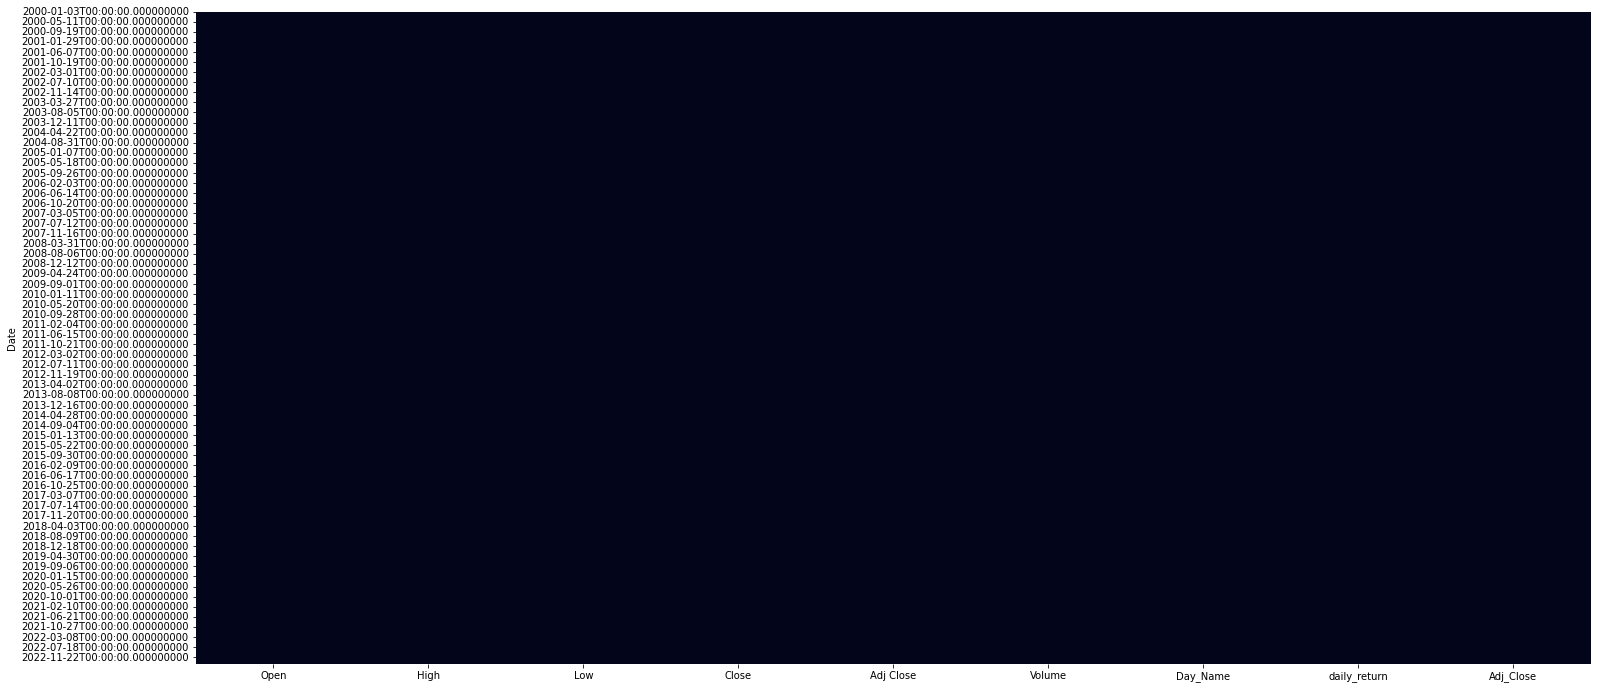

In [ ]:
# no hay faltantes 
plt.figure(figsize= (25,12))
sns.heatmap(sp500_index.isnull(), cbar=False)
plt.show()

3. Valores atípicos y apliquemos una técnica para su tratamiento


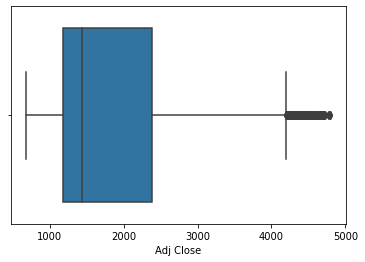

In [ ]:
sns.boxplot(x = 'Adj Close', data = sp500_index)
plt.show()

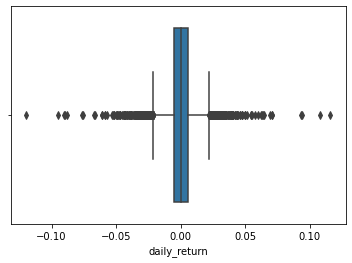

In [ ]:
sns.boxplot(x = 'daily_return', data = sp500_index)
plt.show()

<ipython-input-75-86d068ee542a>:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.dropna will be keyword-only



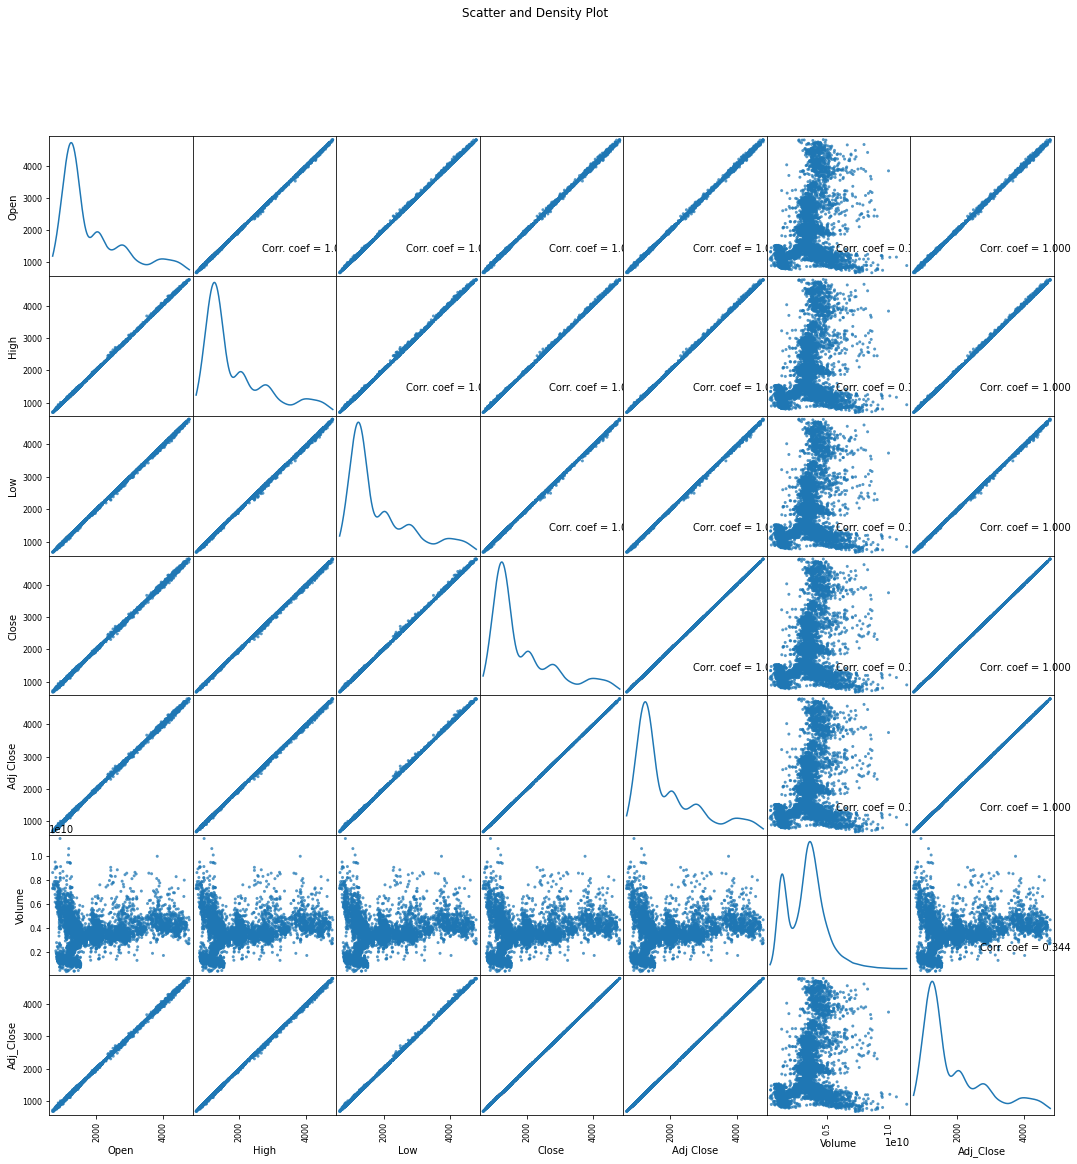

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

plotScatterMatrix(sp500_index, 18, 10)



In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Matriz de Correlacion', fontsize=15)
    plt.show()

<ipython-input-76-abef3e1f696e>:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.dropna will be keyword-only



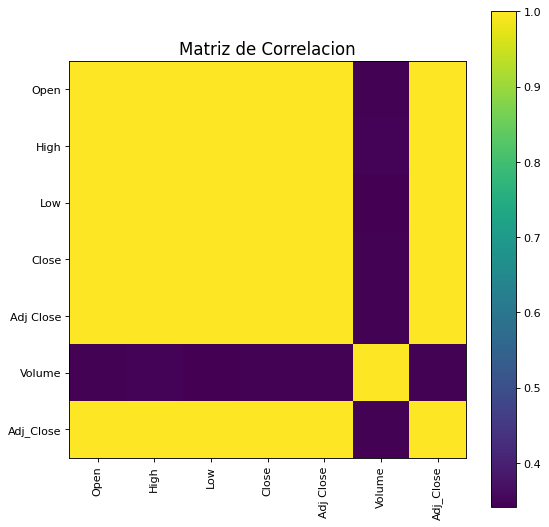

In [ ]:
plotCorrelationMatrix(sp500_index,8)



---



---

#Tendencia del SP500 en el tiempo


---



---



In [ ]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
sp500_index_ciclo, sp500Indice_tend = sm.tsa.filters.hpfilter(sp500_index['Adj Close'])
sp500_index['tend'] = sp500Indice_tend

In [ ]:
fig = go.Figure(data=go.Scatter(x=sp500_index.index, y=sp500_index['tend']))
fig.update_layout(title='S&P 500 Index',
                  xaxis_title='Date',
                  yaxis_title='tend Price', 
                  plot_bgcolor='black',
                  xaxis=dict(linecolor='white', showgrid=False),
                  yaxis=dict(linecolor='white', showgrid=False),)

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=5, label="5y", step="year", stepmode="backward"),
                dict(label="All", step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    yaxis=dict(
        fixedrange=False
    ),
    margin=dict(l=50, r=50, b=50, t=50, pad=4),
    height=600,
)

fig.show()


In [ ]:
fig = go.Figure(data=[go.Candlestick(x=sp500_index.index,
                open=sp500_index['Open'],
                high=sp500_index['High'],
                low=sp500_index['Low'],
                close=sp500_index['Close'])])

fig.update_layout(title='S&P 500 Index',
                  xaxis_title='Date',
                  yaxis_title='Price', 
                  plot_bgcolor='black',
                  xaxis=dict(linecolor='white', showgrid=False),
                  yaxis=dict(linecolor='white', showgrid=False),)

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=5, label="5y", step="year", stepmode="backward"),
                dict(label="All", step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    yaxis=dict(
        fixedrange=False
    ),
    margin=dict(l=50, r=50, b=50, t=50, pad=4),
    height=600,
)

fig.show()





---



---


#La volatilidad del índice SP500 en diferentes periodos de tiempo.


---



---



Calcular la volatilidad en diferentes períodos de tiempo


In [ ]:
sp500_index['volatility_1m'] = sp500_index['daily_return'].rolling(window=21).std() * (252 ** 0.5)
sp500_index['volatility_3m'] = sp500_index['daily_return'].rolling(window=63).std() * (252 ** 0.5)
sp500_index['volatility_6m'] = sp500_index['daily_return'].rolling(window=126).std() * (252 ** 0.5)
sp500_index['volatility_1y'] = sp500_index['daily_return'].rolling(window=252).std() * (252 ** 0.5)


# Crear un gráfico interactivo de la volatilidad en diferentes períodos de tiempo
fig = go.Figure()
fig.add_trace(go.Scatter(x=sp500_index.index, y=sp500_index['volatility_1m'], name='1 month'))
fig.add_trace(go.Scatter(x=sp500_index.index, y=sp500_index['volatility_3m'], name='3 months'))
fig.add_trace(go.Scatter(x=sp500_index.index, y=sp500_index['volatility_6m'], name='6 months'))
fig.add_trace(go.Scatter(x=sp500_index.index, y=sp500_index['volatility_1y'], name='1 year'))

fig.update_layout(title='Volatility of S&P 500 Index in Different Time Periods',
                  xaxis_title='Date',
                  yaxis_title='Volatility',
                  yaxis_tickformat = '%',
                  xaxis_rangeslider_visible=True,
                  plot_bgcolor='black',
                  xaxis=dict(linecolor='white', showgrid=False),
                  yaxis=dict(linecolor='white', showgrid=False),)

fig.show()




---



---


#La distribución de los rendimientos del índice.

---



---



In [ ]:
# Eliminar la primera fila, que contiene un NaN debido a que no hay retorno
# para el primer día en la serie temporal.
sp500_index.dropna(inplace=True)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=sp500_index['daily_return'], nbinsx=50))
fig.update_layout(title='Distribution of S&P 500 Daily Returns',
                  xaxis_title='Daily Return',
                  yaxis_title='Frequency',
                  yaxis_tickformat = '%',
                  xaxis_rangeslider_visible=True,
                  plot_bgcolor='black',
                  xaxis=dict(linecolor='white', showgrid=False),
                  yaxis=dict(linecolor='white', showgrid=False))

fig.show()



---



---

#Los valores atípicos (outliers) en los rendimientos del índice.


---



---



<AxesSubplot:xlabel='daily_return'>

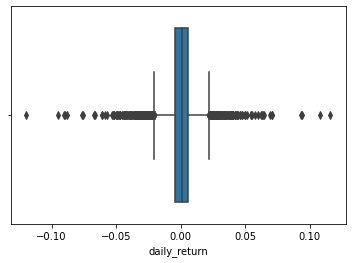

In [ ]:
import seaborn as sns
# Creamos un diagrama de caja de los rendimientos del índice S&P 500
sns.boxplot(x=sp500_index["daily_return"])

#SP500 con los sectores

Cargo los datos donde vienen por sector y empresa el sp500

In [ ]:
subsector_data=pd.read_csv('/content/drive/MyDrive/subsector_data.csv')
subsector_data.set_index('Date', inplace=True)

#Agrego que el indice es una fecha para poder realizar los pasos
subsector_data.index = pd.to_datetime(subsector_data.index)


In [ ]:
subsector_data['Day_Name'] = subsector_data.index.day_name()
subsector_data['daily_return']=subsector_data['Close'].pct_change() 

In [ ]:
subsector_data.head(2)

,Open,High,Low,Close,Adj Close,Volume,Symbol,Sector,Subsector,Day_Name,daily_return
Date,,,,,,,,,,,
2000-01-03,48.03125,48.25000,47.03125,47.1875,25.525520,2173400,MMM,Industriales,Conglomerados Industriales,Monday,NaN
2000-01-04,46.43750,47.40625,45.31250,45.3125,24.511253,2713800,MMM,Industriales,Conglomerados Industriales,Tuesday,-0.039735


# EDA

1. Valores Duplicados

In [ ]:
subsector_data[subsector_data.duplicated()]

,Open,High,Low,Close,Adj Close,Volume,Symbol,Sector,Subsector,Day_Name,daily_return
Date,,,,,,,,,,,
2012-05-23,7.700000,7.700000,7.700000,7.700000,5.364415,0,AMCR,Materiales,Empaquetado de Papel,Wednesday,0.0
2012-05-24,7.700000,7.700000,7.700000,7.700000,5.364415,0,AMCR,Materiales,Empaquetado de Papel,Thursday,0.0
2012-05-25,7.700000,7.700000,7.700000,7.700000,5.364415,0,AMCR,Materiales,Empaquetado de Papel,Friday,0.0
2012-05-29,7.700000,7.700000,7.700000,7.700000,5.364415,0,AMCR,Materiales,Empaquetado de Papel,Tuesday,0.0
2012-05-30,7.700000,7.700000,7.700000,7.700000,5.364415,0,AMCR,Materiales,Empaquetado de Papel,Wednesday,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2002-02-08,12.373333,12.373333,12.373333,12.373333,12.372569,0,TTWO,Servicios de Comunicación,Entretenimiento Doméstico Interactivo,Friday,0.0
2002-02-11,12.373333,12.373333,12.373333,12.373333,12.372569,0,TTWO,Servicios de Comunicación,Entretenimiento Doméstico Interactivo,Monday,0.0
2002-02-12,12.373333,12.373333,12.373333,12.373333,12.372569,0,TTWO,Servicios de Comunicación,Entretenimiento Doméstico Interactivo,Tuesday,0.0


In [ ]:
#Parecen ser 779, eliminamos los duplicados
subsector_data.drop_duplicates(inplace = True)


2. Valores Faltantes

In [ ]:
# solo hay un valor faltante y es debido a la forma en que se calcula el 
#daily_return, es decir la variacion del precio del activo 
subsector_data.isna().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Symbol          0
Sector          0
Subsector       0
Day_Name        0
daily_return    1
dtype: int64

3. Valores Atipicos


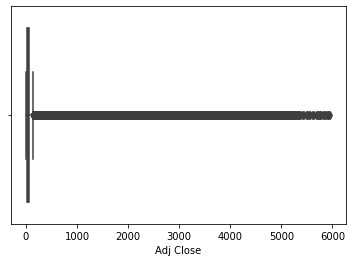

In [ ]:
sns.boxplot(x = 'Adj Close', data = subsector_data)
plt.show()

In [ ]:
subsector_data['Adj Close'].max()

5959.330078125

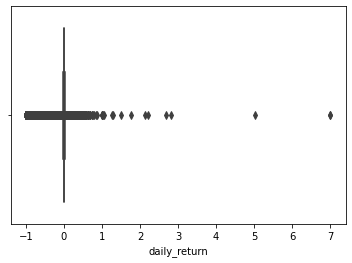

In [ ]:
sns.boxplot(x = 'daily_return', data = subsector_data)
plt.show()

<ipython-input-75-86d068ee542a>:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.dropna will be keyword-only



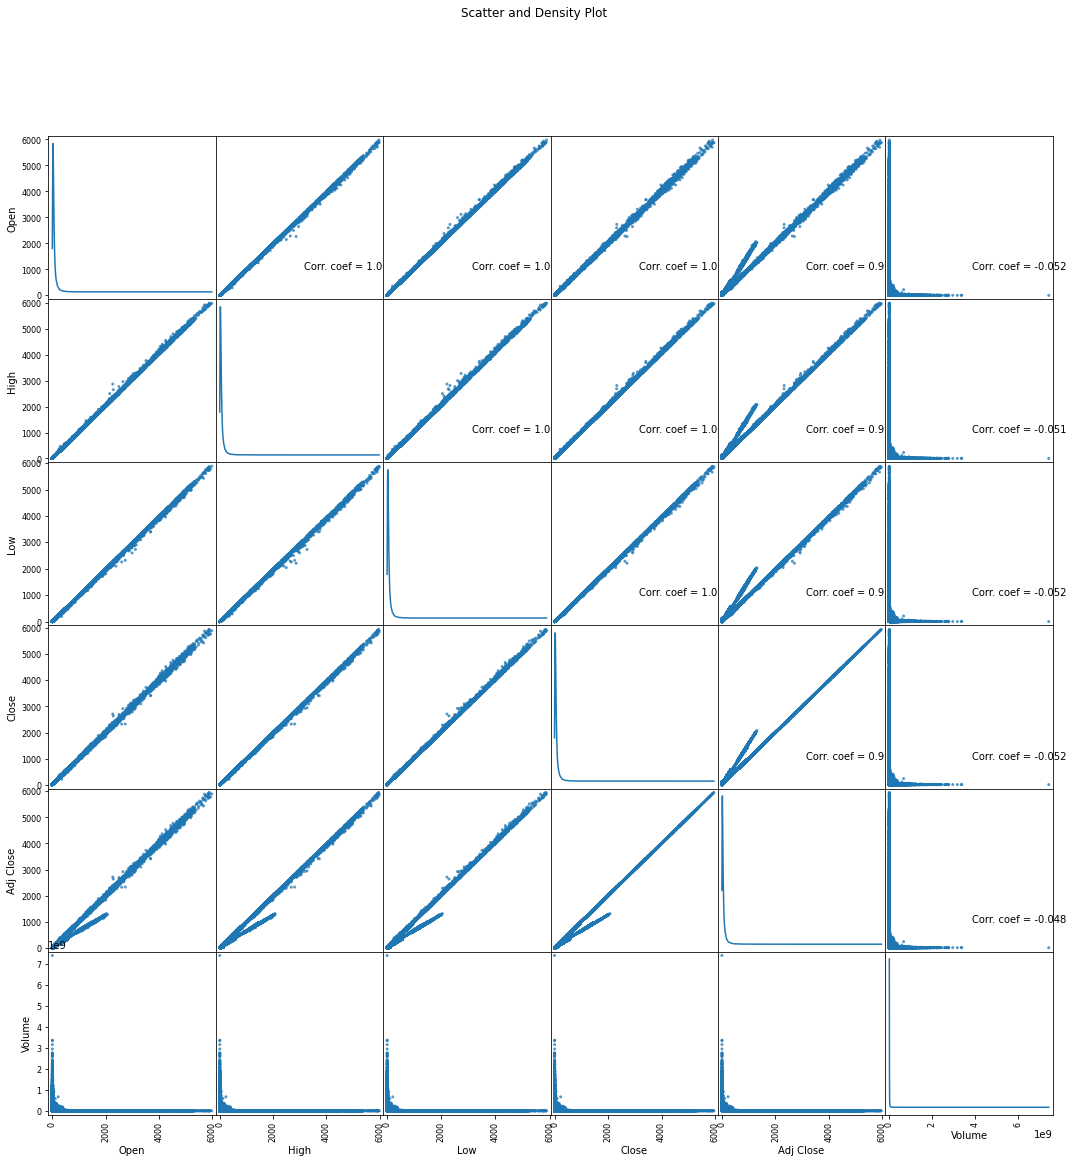

In [ ]:
plotScatterMatrix(subsector_data, 18, 10)

<ipython-input-76-abef3e1f696e>:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.dropna will be keyword-only



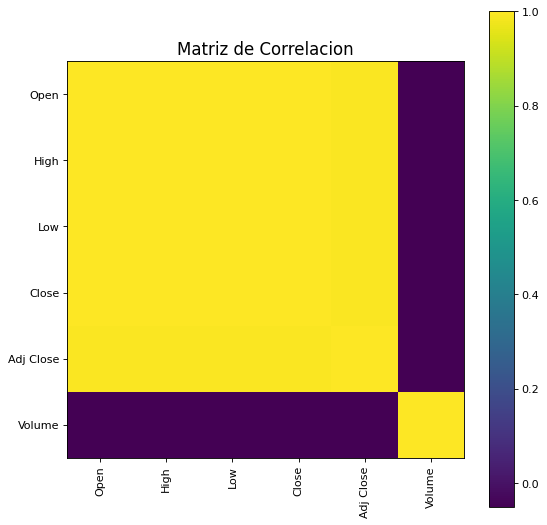

In [ ]:
plotCorrelationMatrix(subsector_data,8)

---
# Probando otra forma de hacer el analisis
---
---

In [ ]:
subsector_data.head(2)
subsector=subsector_data.copy()
subsector_data.to_csv('/content/drive/MyDrive/subsector_data1.csv')
subsector.head(2)

,Open,High,Low,Close,Adj Close,Volume,Symbol,Sector,Subsector,Day_Name,daily_return
Date,,,,,,,,,,,
2000-01-03,48.03125,48.25000,47.03125,47.1875,25.525520,2173400,MMM,Industriales,Conglomerados Industriales,Monday,NaN
2000-01-04,46.43750,47.40625,45.31250,45.3125,24.511253,2713800,MMM,Industriales,Conglomerados Industriales,Tuesday,-0.039735


In [ ]:
empresas_por_sector = subsector.groupby('Sector')['Symbol'].nunique()
empresas_por_sector

Sector
Bienes Raíces                30
Consumo Discrecional         56
Cuidado de Salud             64
Energía                      23
Finanzas                     67
Industriales                 70
Materiales                   29
Productos básicos            33
Servicios de Comunicación    25
Tecnología Informática       76
Utilidades                   30
Name: Symbol, dtype: int64

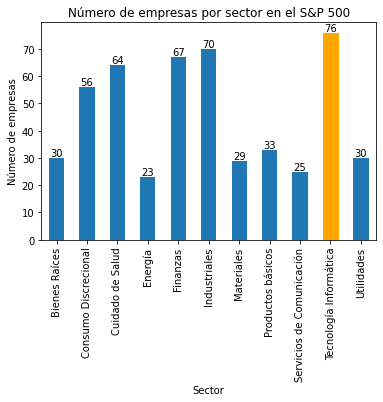

In [ ]:

empresas_por_sector.plot(kind='bar')

# Agregar etiquetas a las barras
for i, v in enumerate(empresas_por_sector.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
    
plt.title('Número de empresas por sector en el S&P 500')
plt.xlabel('Sector')
plt.ylabel('Número de empresas')

# Resaltar la barra más alta
max_index = np.argmax(empresas_por_sector)
plt.gca().patches[max_index].set_color('orange')

plt.show()

In [ ]:
# Agrupar los datos por sector y año, y calcular el rendimiento anual promedio
grouped_data = subsector.groupby(['Sector', pd.Grouper(freq='Y')])['Close'].mean().reset_index()
grouped_data = grouped_data.rename(columns={'Median_Close': 'Median_Close'})
grouped_data



,Sector,Date,Close
0,Bienes Raíces,2000-12-31,28.773788
1,Bienes Raíces,2001-12-31,26.899284
2,Bienes Raíces,2002-12-31,25.357977
3,Bienes Raíces,2003-12-31,27.353897
4,Bienes Raíces,2004-12-31,34.678659
...,...,...,...
259,Utilidades,2019-12-31,66.419345
260,Utilidades,2020-12-31,66.284006
261,Utilidades,2021-12-31,69.328349
262,Utilidades,2022-12-31,74.133420


In [ ]:
grouped_data.to_csv('/content/drive/MyDrive/grouped_data.csv')

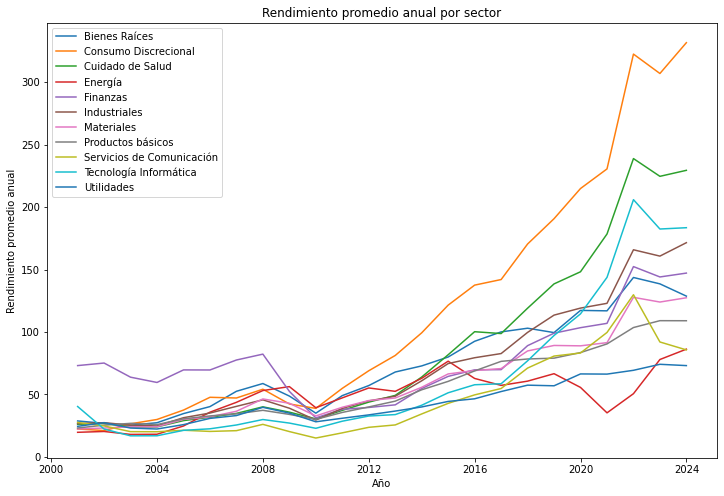

In [ ]:
# Crear una figura y un conjunto de ejes
fig, ax = plt.subplots(figsize=(12,8))

# Iterar sobre cada sector y graficar su rendimiento promedio anual
for sector, data in grouped_data.groupby('Sector'):
    ax.plot(data['Date'], data['Close'], label=sector)

# Agregar un título y etiquetas a los ejes
ax.set_title('Rendimiento promedio anual por sector')
ax.set_xlabel('Año')
ax.set_ylabel('Rendimiento promedio anual')
ax.legend()

# Mostrar la gráfica
plt.show()


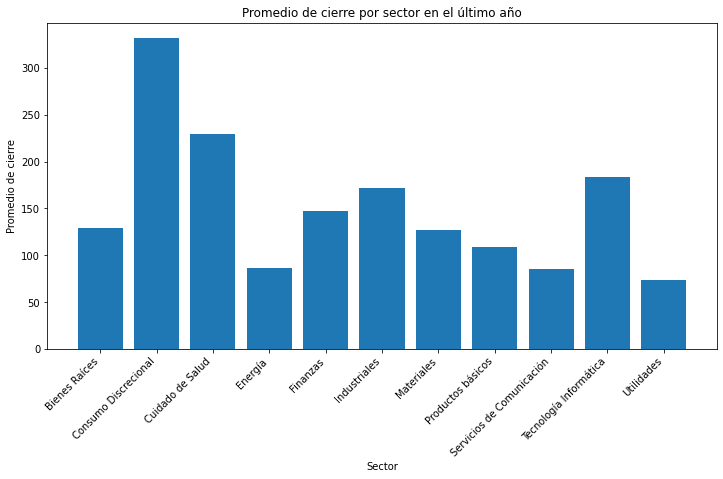

In [ ]:
# Filtrar los datos para seleccionar el último año
last_year = grouped_data['Date'].max()
last_year_data = grouped_data.query('Date == @last_year')

# Graficar los datos
plt.figure(figsize=(12, 6))
plt.bar(last_year_data['Sector'], last_year_data['Close'])
plt.xlabel('Sector')
plt.ylabel('Promedio de cierre')
plt.title('Promedio de cierre por sector en el último año')

plt.xticks(rotation=45, ha='right')

plt.show()

# Rentabilidad anual

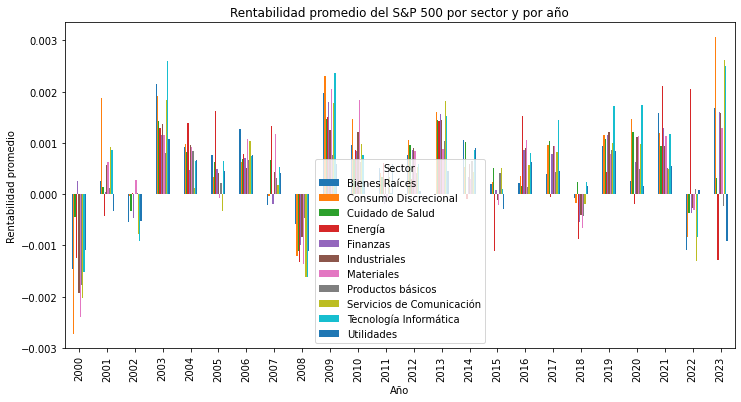

In [ ]:
# Agrupar los datos por sector y por año, y calcular la rentabilidad promedio
returns_by_sector_year = subsector.groupby(['Sector', subsector.index.year])['daily_return'].mean()

# Reorganizar los datos para que cada sector sea una columna y cada año sea un índice
returns_by_sector_year = returns_by_sector_year.unstack('Sector')

# Graficar los resultados
returns_by_sector_year.plot(kind='bar', figsize=(12,6))
plt.xlabel('Año')
plt.ylabel('Rentabilidad promedio')
plt.title('Rentabilidad promedio del S&P 500 por sector y por año')
plt.show()


In [ ]:

returns_by_sector_year.to_csv('/content/drive/MyDrive/returns_by_sector_year.csv')

In [2]:
import pandas as pd
returns_by_sector_year=pd.read_csv('/content/drive/MyDrive/returns_by_sector_year.csv')

Desde el punto de vista de rentabilidad media, los sectores más atractivos son:


Sector(Media)
- Tecnología Informática -------	0.000704
- Consumo Discrecional -------- 	  0.000686
- Cuidado de Salud----------------  	0.000559

Definicion 1. Del riesgo
El riesgo es la volatilidad, la rapidez en que cambian sus valores de acciones, en este caso entre mas pequeña es la desviacion estandar es menos riesgosa

Sector(Desv)
-  Productos básicos-------------	0.000594
-  Utilidades--------------------------- 0.000618
-  Cuidado de Salud--------------	0.000656


Definicion 2. Del Riesgo Probabilidad de pérdida permanente de capital. En otras palabras los sectores más seguros es donde el percentil mas bajo sea mas grande. 
Sector(25%)
- Cuidado de Salud  0.000218
- Tecnología Informática  0.000205
- Consumo Discrecional  0.000173

In [3]:
returns_by_sector_year.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Date,24.0,2011.500000,7.071068,2000.000000,2005.750000,2011.500000,2017.250000,2023.000000
Bienes Raíces,24.0,0.000496,0.000909,-0.001459,-0.000025,0.000451,0.000980,0.002143
Consumo Discrecional,24.0,0.000686,0.001213,-0.002721,0.000173,0.000791,0.001456,0.003063
Cuidado de Salud,24.0,0.000559,0.000656,-0.001108,0.000218,0.000663,0.001015,0.001470
Energía,24.0,0.000441,0.001097,-0.001333,-0.000258,0.000515,0.001396,0.002103
Finanzas,24.0,0.000505,0.000738,-0.000996,-0.000026,0.000555,0.000939,0.001799
Industriales,24.0,0.000540,0.000823,-0.001937,0.000167,0.000742,0.001143,0.001584
Materiales,24.0,0.000516,0.001001,-0.002400,-0.000081,0.000858,0.001136,0.002055
Productos básicos,24.0,0.000294,0.000594,-0.001776,0.000113,0.000425,0.000657,0.001043
Servicios de Comunicación,24.0,0.000447,0.001105,-0.002036,0.000043,0.000524,0.000986,0.002625


# Recomendacion de sectores a invertir

A modo de resumen:

<img src = "https://drive.google.com/uc?id=1e24yo5VIRrJw0Kb7KWz6dVSuYKHAwlU4" height = 400>

La recomendacion es, invertir en los sectores de:

- Cuidado de Salud, es poco rentable, pero es seguro debido a que cumple con las dos definiciones de poco riesgo.

- Tecnologia Informatica y Consumo Discrecional, es rentable, solo cumple con una definicion de riesgo.





# Empresas menos volátiles

Utilizando la definicion de riesgo en donde la menor desviacion estandar significa que es menos volatil, por lo cual es mas estable la empresa. Obtenemos

In [ ]:
subsector.head(2)

,Open,High,Low,Close,Adj Close,Volume,Symbol,Sector,Subsector,Day_Name,daily_return
Date,,,,,,,,,,,
2000-01-03,48.03125,48.25000,47.03125,47.1875,25.525520,2173400,MMM,Industriales,Conglomerados Industriales,Monday,NaN
2000-01-04,46.43750,47.40625,45.31250,45.3125,24.511253,2713800,MMM,Industriales,Conglomerados Industriales,Tuesday,-0.039735


In [ ]:
std_by_company = subsector.groupby('Symbol')['Close'].std()
top_5 = std_by_company.nsmallest(5)
top_5

for symbol in top_5.index:
    sector = subsector.loc[subsector['Symbol'] == symbol, 'Sector'].unique()[0]
    std = top_5[symbol]
    print(f"Symbol: {symbol}, Sector: {sector}, Std: {std}")



Symbol: AMCR, Sector: Materiales, Std: 1.193257415190925
Symbol: HPE, Sector: Tecnología Informática, Std: 2.559824034037786
Symbol: NWS, Sector: Servicios de Comunicación, Std: 3.461011428069711
Symbol: OGN, Sector: Cuidado de Salud, Std: 3.7148709875940003
Symbol: NWSA, Sector: Servicios de Comunicación, Std: 3.7419981874618817


In [ ]:
sectores_interes = ['Tecnología Informática', 'Cuidado de Salud', 'Consumo Discrecional']
empresas_seleccionadas = subsector[subsector['Sector'].isin(sectores_interes)]
std_by_company = empresas_seleccionadas.groupby('Symbol')['Close'].std()
top_5 = std_by_company.nsmallest(5)

for symbol in top_5.index:
    sector = empresas_seleccionadas.loc[empresas_seleccionadas['Symbol'] == symbol, 'Sector'].unique()[0]
    std = top_5[symbol]
    print(f"Symbol: {symbol}, Sector: {sector}, Std: {std}")



Symbol: HPE, Sector: Tecnología Informática, Std: 2.559824034037786
Symbol: OGN, Sector: Cuidado de Salud, Std: 3.7148709875940003
Symbol: F, Sector: Consumo Discrecional, Std: 5.245127806773436
Symbol: GEHC, Sector: Cuidado de Salud, Std: 5.945841602772125
Symbol: GEN, Sector: Tecnología Informática, Std: 6.13902326473464


Text(0.5, 0, 'Companies')

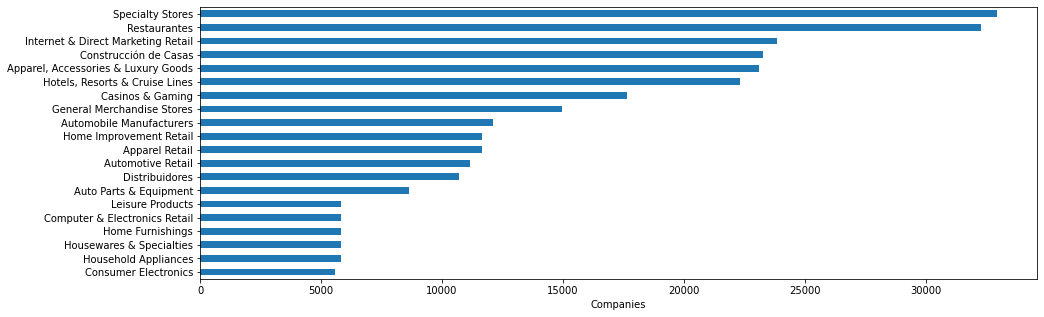

In [ ]:
#plot Sub-Industry by number of company
sector = 'Consumo Discrecional'

#data for plot
sector_df = subsector[subsector['Sector'] == sector]['Subsector'].value_counts(ascending=True)

#plot
fig, ax= plt.subplots(figsize=(15, 5))

#bar plot
sector_df.plot(kind='barh', ax=ax)
ax.set_xlabel('Companies')

In [ ]:
subsector[subsector.Subsector=='Specialty Stores']['Symbol'].unique()

array(['AZO', 'BBWI', 'GPC', 'ORLY', 'TSCO', 'ULTA'], dtype=object)

# Retorno
El retorno se refiere al cambio en el valor de una inversión durante un período de tiempo. Es una medida de la rentabilidad de una inversión y puede ser expresado como un porcentaje o una cantidad monetaria. 

In [ ]:
retornoTotal = (subsector.groupby('Symbol')['Close'].last() - subsector.groupby('Symbol')['Close'].first()) / subsector.groupby('Symbol')['Close'].first()
# Seleccionar las diez primeras compañías con el mayor retorno total
retornoTotalTop10 = retornoTotal.nlargest(10)
retornoTotalTop10



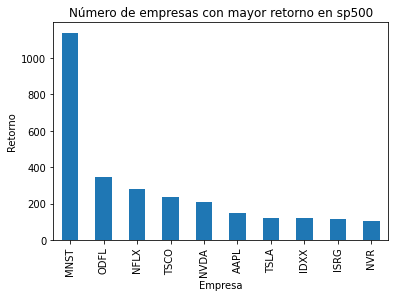

In [ ]:
retornoTotalTop10.plot(kind='bar')

    
plt.title('Número de empresas con mayor retorno en sp500')
plt.xlabel('Empresa')
plt.ylabel('Retorno')



plt.show()